<a href="https://colab.research.google.com/github/NanakiOhashi-JP/fingerDetection/blob/main/Real_time_finger_detection_using_webcam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
koryakinp_fingers_path = kagglehub.dataset_download('koryakinp/fingers')

print('Data source import complete.')
print(f'Downloaded data path: {koryakinp_fingers_path}') # Added print

Data source import complete.
Downloaded data path: /kaggle/input/fingers


In [25]:
!pwd

/content


# Fingers Recognition in Real Time

### Check out the full article [here](https://medium.com/@guptakgk14/947222db71b0)

## Importing Libraries

In [26]:
import os
import cv2
import glob
import keras
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.layers import Input,Dense,Conv2D,MaxPooling2D,BatchNormalization,Flatten,Dropout

## Loading the dataset

In [27]:
TRAIN_PATH = '/kaggle/input/fingers/fingers/train/*'
TEST_PATH = '/kaggle/input/fingers/fingers/test/*'
FILE_NAME = 'realtime_fingers_detection.keras'
MODEL_PATH = 'realtime_fingers_model/'
KERNEL = (3,3)
CLASSES = 6
IMAGE_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 50

## Util Functions

In [28]:
def load_dataset(path):
    dataset = [(int(img_path[-6]), load_image(img_path)) for img_path in glob.glob(path)]
    return dataset

def load_image(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.uint8)
    img = np.reshape(img, (IMAGE_SIZE, IMAGE_SIZE))
    return img

def show_image(img):
    imgplot = plt.imshow(img, cmap='gray')
    plt.show()

def show_images(dataset, grid_size=5):
    _, axes = plt.subplots(grid_size, grid_size, figsize=(12, 12))
    axes = [y for x in axes for y in x]
    for (i, (label, img)) in enumerate(random.sample(dataset, grid_size**2)):
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(label)
        axes[i].axis('off')

def process_stream_image(img):
    img = cv2.copyMakeBorder(img.copy(), 50, 50, 50, 50, cv2.BORDER_CONSTANT, value=[255, 255, 255])
    img = process_image(img, thresh_low=70, thresh_high=250)
    img[img < 1] = 0
    return img

def process_image(img, thresh_low=80, thresh_high=255):
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    img = cv2.GaussianBlur(img, (5, 5), 0)
    _, img = cv2.threshold(img, thresh_low, thresh_high, cv2.THRESH_BINARY)
    im_floodfill = img.copy()
    h, w = img.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)
    cv2.floodFill(im_floodfill, mask, (0,0), 255)
    im_floodfill_inv = cv2.bitwise_not(im_floodfill)
    img = img | im_floodfill_inv
    img = img/255
    img = np.reshape(img, (IMAGE_SIZE, IMAGE_SIZE, 1))
    return img

def process_dataset(dataset):
    dataset = [(label, process_image(img)) for (label, img) in dataset]
    return dataset

In [29]:
train_set = load_dataset(TRAIN_PATH)
test_set = load_dataset(TEST_PATH)

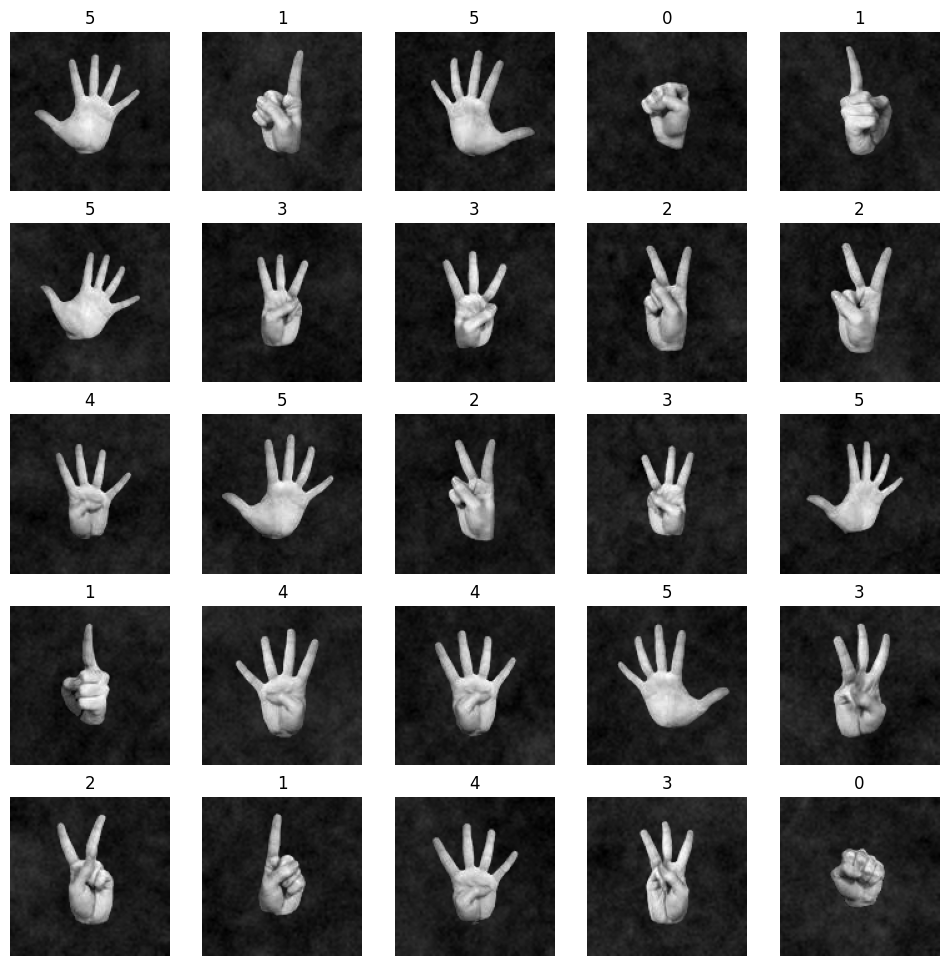

In [30]:
show_images(train_set)

## Modify the data

For real time image processing we are going to convert the video feed from the web cam to a black and white image and then will pass it to the model for inference. So we have to train our model on that data.
We will now convert our color images to grayscale and then to black and white masks.

In [31]:
training_set = process_dataset(train_set)
testing_set = process_dataset(test_set)

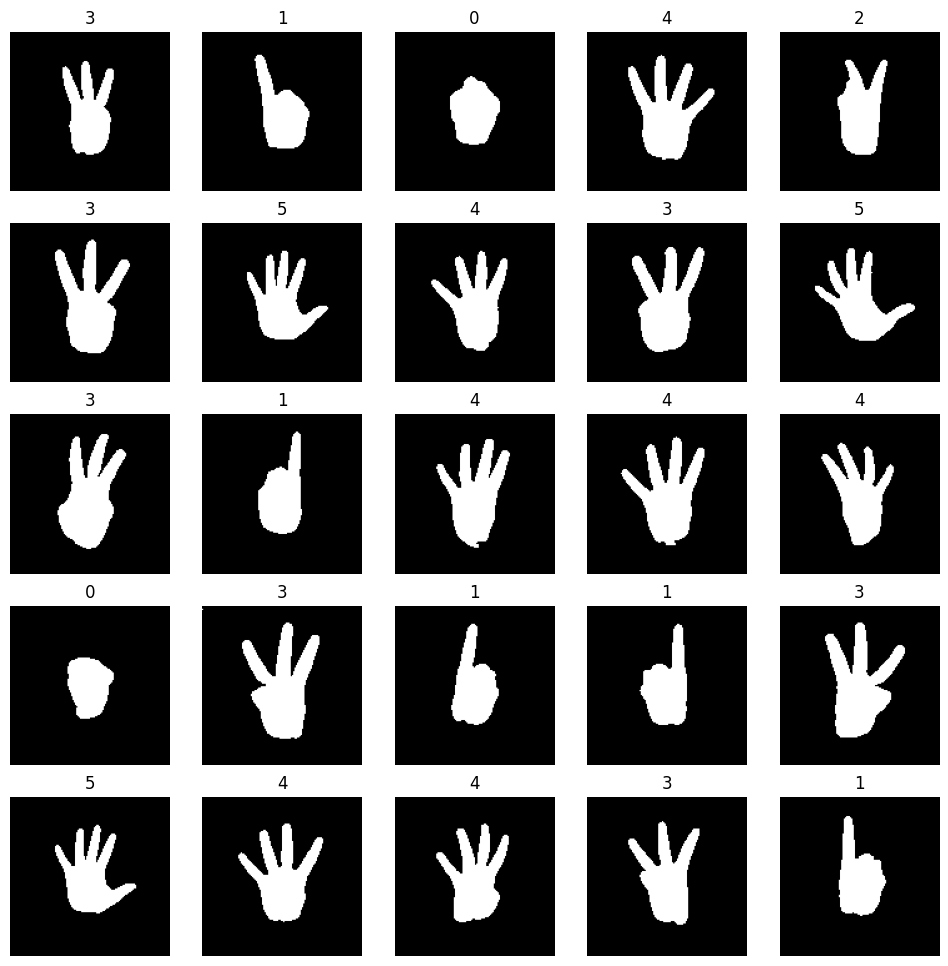

In [32]:
show_images(training_set)

## Splitting the dataset in Images and labels

In [33]:
X_train = np.array([img for (_, img) in training_set])
Y_train = keras.utils.to_categorical([label for (label, _) in training_set], num_classes=CLASSES)
X_test = np.array([img for (_, img) in testing_set])
Y_test = keras.utils.to_categorical([label for (label, _) in testing_set], num_classes=CLASSES)

In [34]:
print(X_train.shape)
print(Y_train.shape)

(18000, 128, 128, 1)
(18000, 6)


## Data Augmentation

Generating modified data using the given dataset. We will scale, rotate and transform these images to generate a variety of images for our dataset.

In [35]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_generator = ImageDataGenerator(
                    rotation_range=45,
                    zoom_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range = 0.1,
                    horizontal_flip=False,
                    fill_mode="nearest"
                )

## Creating the Model

In [36]:
def get_model():
    input_shape=[IMAGE_SIZE, IMAGE_SIZE, 1]

    model = keras.models.Sequential([
            Input(input_shape),
            Conv2D(64, KERNEL, strides=(1, 1), activation='relu'),
            MaxPooling2D((2, 2)),
            BatchNormalization(),
            Conv2D(128, KERNEL, strides=(1, 1), activation='relu'),
            MaxPooling2D((2, 2)),
            BatchNormalization(),
            Conv2D(256, KERNEL, strides=(1, 1), activation='relu'),
            MaxPooling2D((2, 2)),
            BatchNormalization(),
            Conv2D(64, KERNEL, strides=(1, 1), activation='relu'),
            MaxPooling2D((2, 2)),
            BatchNormalization(),
            Dropout(0.2),
            Flatten(),
            Dense(CLASSES, activation="softmax"),
        ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

## Model Training

In [37]:
checkpoint = ModelCheckpoint(FILE_NAME, monitor='loss', verbose=1, save_best_only=True, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='loss', verbose=1, factor=0.5, patience=1, min_lr=0.0001, mode='min')
earlyStopping = EarlyStopping(monitor='val_loss', verbose=1, min_delta=0, restore_best_weights = True, patience=3, mode='min')
callbacks_list = [checkpoint, earlyStopping, reduce_lr]

model = get_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 63, 63, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 30, 30, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 64)     │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 6, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │        13,830 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 533,062 (2.03 MB)

 Trainable params: 532,038 (2.03 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [38]:
# Training the model if the model is not saved
history = model.fit(
        x = img_generator.flow(X_train, Y_train, batch_size=BATCH_SIZE),
        steps_per_epoch= X_train.shape[0] // BATCH_SIZE,
        validation_data= img_generator.flow(X_test, Y_test, batch_size=BATCH_SIZE),
        validation_steps= X_test.shape[0] // BATCH_SIZE,
        epochs= EPOCHS,
        callbacks= callbacks_list
    )

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


562/562 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.6615 - loss: 0.8620
Epoch 1: loss improved from inf to 0.56659, saving model to realtime_fingers_detection.keras
562/562 ━━━━━━━━━━━━━━━━━━━━ 55s 79ms/step - accuracy: 0.6617 - loss: 0.8615 - val_accuracy: 0.4634 - val_loss: 1.3070 - learning_rate: 1.0000e-04
Epoch 2/50
  1/562 ━━━━━━━━━━━━━━━━━━━━ 26s 47ms/step - accuracy: 0.8438 - loss: 0.3123

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: loss improved from 0.56659 to 0.31232, saving model to realtime_fingers_detection.keras
562/562 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.8438 - loss: 0.3123 - val_accuracy: 0.4699 - val_loss: 1.2876 - learning_rate: 1.0000e-04
Epoch 3/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9262 - loss: 0.2473
Epoch 3: loss improved from 0.31232 to 0.21707, saving model to realtime_fingers_detection.keras
562/562 ━━━━━━━━━━━━━━━━━━━━ 82s 103ms/step - accuracy: 0.9262 - loss: 0.2473 - val_accuracy: 0.9701 - val_loss: 0.1349 - learning_rate: 1.0000e-04
Epoch 4/50
  1/562 ━━━━━━━━━━━━━━━━━━━━ 26s 47ms/step - accuracy: 0.9375 - loss: 0.1665
Epoch 4: loss improved from 0.21707 to 0.16654, saving model to realtime_fingers_detection.keras
562/562 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9375 - loss: 0.1665 - val_accuracy: 0.9710 - val_loss: 0.1397 - learning_rate: 1.0000e-04
Epoch 5/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9593 - loss: 0.1523
Epoch 5

In [41]:
# Save only the model weights
WEIGHTS_FILE_NAME = 'realtime_fingers_weights.weights.h5'
model.save_weights(WEIGHTS_FILE_NAME)
print(f"Model weights Saved at path: {WEIGHTS_FILE_NAME}")

# Note: tf.saved_model.save(model, MODEL_PATH) saves the entire model to a directory
# and is not directly compatible with model.load_weights(filepath)
# If you want to save/load the entire model, use the .keras format or tf.saved_model.load
# tf.saved_model.save(model, MODEL_PATH)
# print("Model Saved at path:" + MODEL_PATH)

Model weights Saved at path: realtime_fingers_weights.weights.h5


In [43]:
# Load the model weights from the saved file
# Ensure you use the correct file name where weights were saved
WEIGHTS_FILE_NAME = 'realtime_fingers_weights.weights.h5' # Define the weights file name again
model.load_weights(WEIGHTS_FILE_NAME)
loss, acc = model.evaluate(X_test, Y_test)
print(f"Model evaluated with Loss: {loss:.4f}, Accuracy: {acc:.4f}")

113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9997 - loss: 0.0054
Model evaluated with Loss: 0.0054, Accuracy: 0.9997


## Plotting the metrics

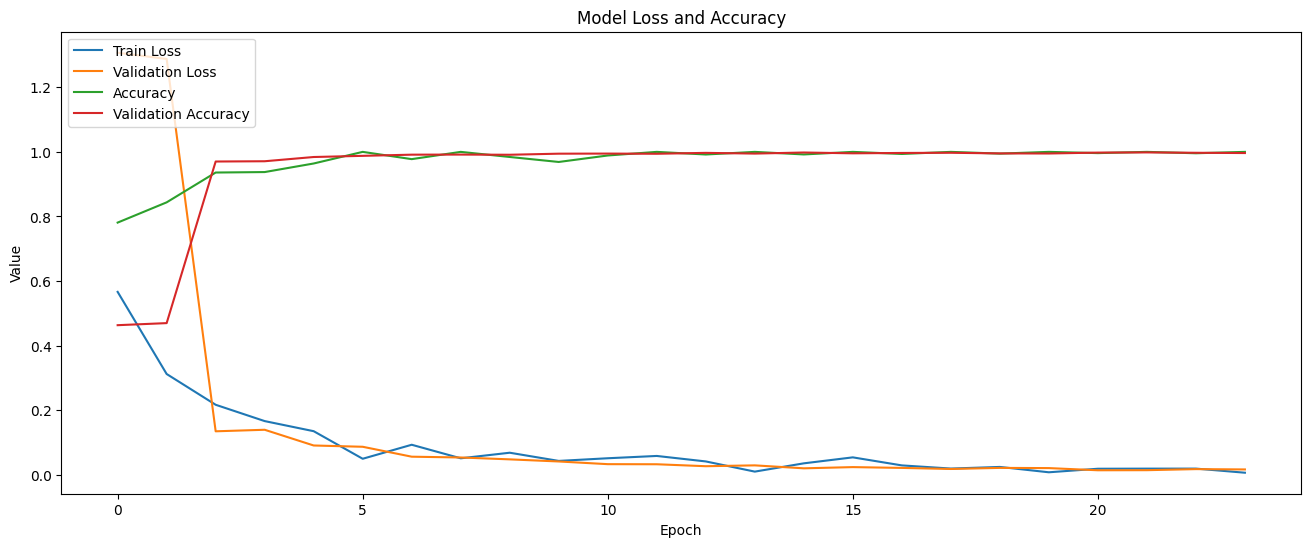

In [44]:
plt.figure(figsize=(16, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Loss and Accuracy')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(['Train Loss', 'Validation Loss', "Accuracy", "Validation Accuracy"], loc='upper left')
plt.savefig('training.png')
plt.show()

## Loading the model

In [45]:
class FingerClassifier(object):
    def __init__(self, model_object):
        self.detect = model_object

    def get_classification(self, img):
        img = img.reshape(1, *img.shape)
        img = tf.constant(img, dtype=float)
        unique, counts = np.unique(img, return_counts=True)
        if (len(counts) <= 1 or counts[1] < 1200):
            return -1;
        output = self.detect(img)
        return np.argmax(output)

In [46]:
obj = FingerClassifier(model)

In [47]:
camMarginX = 10
camMarginY = 10
scale = 10
LB = np.array([0, 90, 0])
UB = np.array([180, 220, 255])
roi = (400, 120, 250, 250)
rval = True

cam = cv2.VideoCapture(0)

while rval:
    rval, img = cam.read()
    img = cv2.flip(img, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    x, y, w, h = roi
    cropped = img[y:y+h, x:x+w]

    cv2.imshow('Original', cropped)
    cropped = process_stream_image(cropped)
    # show_image(cropped)
    cv2.imshow('Mask', cropped)
    fingers = obj.get_classification(cropped)
    print(fingers, end=' ')
    if(cv2.waitKey(25) & 0xFF == 27):
        break;

cam.release()
cv2.destroyAllWindows()

error: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'
